Generación de la Base de Datos

In [3]:
#Cargar los datos desde los archivos CSV y Excel
import pandas as pd

# Rutas de los archivos
covid_file_path = r'E:\5toSemestre\COVID19MEXICO.csv'
catalog_file_path = r'E:\5toSemestre\201128 Catalogos.xlsx'

# Cargar el archivo CSV
covid_data = pd.read_csv(covid_file_path, low_memory=False)

# Cargar los catálogos
catalog_municipios = pd.read_excel(catalog_file_path, sheet_name='Catálogo MUNICIPIOS')
catalog_entidades = pd.read_excel(catalog_file_path, sheet_name='Catálogo de ENTIDADES')

# Verificar la carga de datos
print(covid_data.head())


  FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  SECTOR  ENTIDAD_UM  SEXO  \
0          2024-06-11     g6cbf6b       1       4          32     1   
1          2024-06-11     gbbd8c2       1       4          32     2   
2          2024-06-11     gbabd45       1       4          22     2   
3          2024-06-11     ga7fcdd       1       4           1     2   
4          2024-06-11     gc958d3       1      12          31     1   

   ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES  TIPO_PACIENTE  ... OTRO_CASO  \
0           32           32             56              2  ...         2   
1           32           32             56              2  ...         2   
2            7           22             16              1  ...         2   
3            1            1              1              2  ...         2   
4           31           31             96              1  ...         1   

  TOMA_MUESTRA_LAB RESULTADO_LAB  TOMA_MUESTRA_ANTIGENO  RESULTADO_ANTIGENO  \
0                1             2     

In [4]:
# Filtrar casos confirmados (clave 1)
casos_confirmados = covid_data[covid_data['RESULTADO_LAB'] == 1]

# Verificar los casos confirmados
print(casos_confirmados.head())

   FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  SECTOR  ENTIDAD_UM  SEXO  \
9           2024-06-11     g540757       1       4           9     1   
12          2024-06-11     g9eb8a3       1       4           9     1   
15          2024-06-11     gc1e6a9       1      12          24     2   
34          2024-06-11     gd16cbd       1      15          32     1   
36          2024-06-11     g824984       1       4          32     2   

    ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES  TIPO_PACIENTE  ... OTRO_CASO  \
9             9            9             15              1  ...         2   
12            9            9             15              1  ...         2   
15           24           24             28              1  ...         1   
34           32           32             17              1  ...         2   
36           32           32             17              2  ...         2   

   TOMA_MUESTRA_LAB RESULTADO_LAB  TOMA_MUESTRA_ANTIGENO  RESULTADO_ANTIGENO  \
9                 1     

In [5]:
# Contar casos confirmados por municipio
casos_por_municipio = casos_confirmados.groupby(['ENTIDAD_RES', 'MUNICIPIO_RES']).size().reset_index(name='CASOS_CONFIRMADOS')

# Verificar la tabla final
print(casos_por_municipio.head())

   ENTIDAD_RES  MUNICIPIO_RES  CASOS_CONFIRMADOS
0            1              1                209
1            1              2                  1
2            1              3                  3
3            1              4                  1
4            1              5                  5


In [6]:
# Crear columna de ID para uniones
casos_por_municipio['ID_RES'] = casos_por_municipio["ENTIDAD_RES"].astype(str) + casos_por_municipio["MUNICIPIO_RES"].astype(str)
catalog_municipios['ID'] = catalog_municipios["CLAVE_ENTIDAD"].astype(str) + catalog_municipios["CLAVE_MUNICIPIO"].astype(str)

# Unir con información de municipios y entidades
casos_por_municipio_merged = casos_por_municipio.merge(catalog_municipios[['ID', 'MUNICIPIO', 'CLAVE_ENTIDAD']], left_on='ID_RES', right_on='ID', how='left')
casos_por_municipio_merged = casos_por_municipio_merged.merge(catalog_entidades[['CLAVE_ENTIDAD', 'ENTIDAD_FEDERATIVA']], left_on='CLAVE_ENTIDAD', right_on='CLAVE_ENTIDAD', how='left')

# Verificar la tabla final
print(casos_por_municipio_merged.head())


   ENTIDAD_RES  MUNICIPIO_RES  CASOS_CONFIRMADOS ID_RES  ID       MUNICIPIO  \
0            1              1                209     11  11  AGUASCALIENTES   
1            1              2                  1     12  12        ASIENTOS   
2            1              3                  3     13  13        CALVILLO   
3            1              4                  1     14  14           COSÍO   
4            1              5                  5     15  15     JESÚS MARÍA   

   CLAVE_ENTIDAD ENTIDAD_FEDERATIVA  
0              1     AGUASCALIENTES  
1              1     AGUASCALIENTES  
2              1     AGUASCALIENTES  
3              1     AGUASCALIENTES  
4              1     AGUASCALIENTES  


In [17]:
#Generación de Base de Datos sin Coordenadas
import pandas as pd
from unidecode import unidecode

# Rutas de los archivos
covid_file_path = r'E:\5toSemestre\COVID19MEXICO.csv'
catalogos_path = r'E:\5toSemestre\201128 Catalogos.xlsx'

# Cargar el archivo CSV de datos de COVID
covid_data = pd.read_csv(covid_file_path, low_memory=False)

# Filtrar casos confirmados (clave 1)
casos_confirmados = covid_data[covid_data['RESULTADO_LAB'] == 1]

# Cargar los catálogos
catalog_municipios = pd.read_excel(catalogos_path, sheet_name='Catálogo MUNICIPIOS')
catalog_entidades = pd.read_excel(catalogos_path, sheet_name='Catálogo de ENTIDADES')

# Crear un diccionario para los nombres de las entidades
entidades_dict = catalog_entidades.set_index('CLAVE_ENTIDAD')['ENTIDAD_FEDERATIVA'].to_dict()

# Crear un diccionario para los nombres de los municipios
municipios_dict = catalog_municipios.set_index(['CLAVE_ENTIDAD', 'CLAVE_MUNICIPIO'])['MUNICIPIO'].to_dict()

# Convertir los códigos de entidad y municipio a nombres
casos_confirmados['Nombre del estado de Nacimiento'] = casos_confirmados['ENTIDAD_NAC'].map(entidades_dict)
casos_confirmados['Nombre del Estado de Residencia'] = casos_confirmados['ENTIDAD_RES'].map(entidades_dict)
casos_confirmados['Nombre del Municipio de Residencia'] = casos_confirmados.apply(lambda row: municipios_dict.get((row['ENTIDAD_RES'], row['MUNICIPIO_RES'])), axis=1)

# Aplicar unidecode para eliminar acentos y caracteres especiales
casos_confirmados['Nombre del estado de Nacimiento'] = casos_confirmados['Nombre del estado de Nacimiento'].apply(lambda x: unidecode(x) if pd.notnull(x) else x)
casos_confirmados['Nombre del Estado de Residencia'] = casos_confirmados['Nombre del Estado de Residencia'].apply(lambda x: unidecode(x) if pd.notnull(x) else x)
casos_confirmados['Nombre del Municipio de Residencia'] = casos_confirmados['Nombre del Municipio de Residencia'].apply(lambda x: unidecode(x) if pd.notnull(x) else x)

# Seleccionar y ordenar columnas
columnas_finales = [
    'FECHA_ACTUALIZACION',
    'Nombre del estado de Nacimiento',
    'Latitud Nacimiento',  # Dejar espacio para latitud
    'Longitud Nacimiento',  # Dejar espacio para longitud
    'Numero de Casos Confirmados',
    'Nombre del Estado de Residencia',
    'Latitud Residencia',  # Dejar espacio para latitud
    'Longitud Residencia',  # Dejar espacio para longitud
    'Nombre del Municipio de Residencia',
    'Latitud Municipio Residencia',  # Dejar espacio para latitud
    'Longitud Municipio Residencia'  # Dejar espacio para longitud
]

# Crear DataFrame con las columnas necesarias
resultado_final = pd.DataFrame(columns=columnas_finales)

# Llenar DataFrame con la información disponible
resultado_final['FECHA_ACTUALIZACION'] = casos_confirmados['FECHA_ACTUALIZACION']
resultado_final['Nombre del estado de Nacimiento'] = casos_confirmados['Nombre del estado de Nacimiento']
resultado_final['Numero de Casos Confirmados'] = casos_confirmados['RESULTADO_LAB']  # Puedes ajustar esta columna según la necesidad
resultado_final['Nombre del Estado de Residencia'] = casos_confirmados['Nombre del Estado de Residencia']
resultado_final['Nombre del Municipio de Residencia'] = casos_confirmados['Nombre del Municipio de Residencia']

# Guardar el DataFrame resultante como A17
output_file_path = r'E:\5toSemestre\A19.csv'
resultado_final.to_csv(output_file_path, index=False)

print(f"El archivo A17 se ha guardado en '{output_file_path}'.")


C:\Users\ivana\AppData\Local\Temp\ipykernel_45376\3679555885.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casos_confirmados['Nombre del estado de Nacimiento'] = casos_confirmados['ENTIDAD_NAC'].map(entidades_dict)
C:\Users\ivana\AppData\Local\Temp\ipykernel_45376\3679555885.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casos_confirmados['Nombre del Estado de Residencia'] = casos_confirmados['ENTIDAD_RES'].map(entidades_dict)
C:\Users\ivana\AppData\Local\Temp\ipykernel_45376\3679555885.py:28: 

El archivo A17 se ha guardado en 'E:\5toSemestre\A19.csv'.


In [18]:
import pandas as pd
import requests
import time
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from unidecode import unidecode

# Rutas de los archivos
a19_file_path = r'E:\5toSemestre\A19.csv'
catalogos_path = r'E:\5toSemestre\201128 Catalogos.xlsx'

# Configuración para el geocodificador
URL_BASE = "https://nominatim.openstreetmap.org/search"
USER_AGENT = "AuxilioUcan"
TIMEOUT = 10  # Aumentar tiempo de espera
RETRIES = 5
BACKOFF_FACTOR = 2  # Aumentar factor de retroceso
MAX_WORKERS = 6  # Ajusta según la capacidad de tu CPU

# Limites geográficos de México
MEXICO_BOUNDS = {
    "min_lat": 14.3883,
    "max_lat": 32.716,
    "min_lon": -118.455,
    "max_lon": -86.7034
}

# Cargar el archivo CSV de A19
data_a19 = pd.read_csv(a19_file_path)

# Normalizar los nombres eliminando acentos
data_a19['Nombre del estado de Nacimiento'] = data_a19['Nombre del estado de Nacimiento'].apply(lambda x: unidecode(str(x)))
data_a19['Nombre del Estado de Residencia'] = data_a19['Nombre del Estado de Residencia'].apply(lambda x: unidecode(str(x)))
data_a19['Nombre del Municipio de Residencia'] = data_a19['Nombre del Municipio de Residencia'].apply(lambda x: unidecode(str(x)))

# Caché y lista de errores
cache_coordenadas = {}
errores_geocodificacion = defaultdict(list)

def dentro_de_mexico(lat, lon):
    return (MEXICO_BOUNDS["min_lat"] <= lat <= MEXICO_BOUNDS["max_lat"]) and (MEXICO_BOUNDS["min_lon"] <= lon <= MEXICO_BOUNDS["max_lon"])

def obtener_coordenadas(direccion):
    if direccion in cache_coordenadas:
        return cache_coordenadas[direccion]

    url = f"{URL_BASE}?q={direccion}, Mexico&countrycodes=mx&format=json&limit=1"
    headers = {'User-Agent': USER_AGENT}

    for intento in range(RETRIES):
        try:
            response = requests.get(url, headers=headers, timeout=TIMEOUT)
            response.raise_for_status()

            data = response.json()
            if data:
                lat = float(data[0]['lat'])
                lon = float(data[0]['lon'])
                if dentro_de_mexico(lat, lon):
                    cache_coordenadas[direccion] = (lat, lon)
                    return lat, lon
                else:
                    print(f"Coordenadas fuera de México para: {direccion}")
                    errores_geocodificacion[direccion].append("Fuera de México")
                    return None, None
            else:
                print(f"No se encontraron resultados para: {direccion}")
                errores_geocodificacion[direccion].append(response.status_code)
                return None, None

        except requests.exceptions.RequestException as e:
            time.sleep(BACKOFF_FACTOR * (2**intento))  # Retroceso exponencial
            print(f"Error en la solicitud (Intento {intento + 1}): {e}")
            errores_geocodificacion[direccion].append(str(e))

    print(f"Error persistente al geocodificar: {direccion}")
    return None, None

def geocodificar(data, column_name):
    direcciones = data[column_name].unique()
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        resultados = list(executor.map(obtener_coordenadas, direcciones))
    return dict(zip(direcciones, resultados))

# Geocodificar estados de nacimiento
coords_nacimiento = geocodificar(data_a19, 'Nombre del estado de Nacimiento')
data_a19['Latitud Nacimiento'], data_a19['Longitud Nacimiento'] = zip(*data_a19['Nombre del estado de Nacimiento'].map(coords_nacimiento))

# Geocodificar estados de residencia
coords_residencia = geocodificar(data_a19, 'Nombre del Estado de Residencia')
data_a19['Latitud Residencia'], data_a19['Longitud Residencia'] = zip(*data_a19['Nombre del Estado de Residencia'].map(coords_residencia))

# Geocodificar municipios de residencia
coords_municipio = geocodificar(data_a19, 'Nombre del Municipio de Residencia')
data_a19['Latitud Municipio Residencia'], data_a19['Longitud Municipio Residencia'] = zip(*data_a19['Nombre del Municipio de Residencia'].map(coords_municipio))




No se encontraron resultados para: NO ESPECIFICADO
El archivo A19 con coordenadas se ha guardado en 'A19_con_coordenadas.csv'.


In [20]:
# Guardar el DataFrame resultante como A19 con coordenadas
output_file_path = r'E:\5toSemestre\A19_con_coordenadas.csv'
data_a19.to_csv(output_file_path, index=False)

print(f"El archivo A19 con coordenadas se ha guardado en '{output_file_path}'.")

El archivo A19 con coordenadas se ha guardado en 'E:\5toSemestre\A19_con_coordenadas.csv'.


En este chunk obtenemos unicamente las coordenadas de municipios que están dentro de la republica mexicana

In [21]:
import os
import pandas as pd

# Ruta de la carpeta que contiene el archivo CSV original
folder_path = r'E:\5toSemestre'

# Nombre del archivo CSV original
input_file_name = r'E:\5toSemestre\A19_con_coordenadas.csv'

# Construir la ruta completa del archivo
input_file_path = os.path.join(folder_path, input_file_name)

# Verificar si el archivo existe
if os.path.exists(input_file_path):
    # Leer el archivo CSV original
    data_a19 = pd.read_csv(input_file_path)

    # Especificar los valores a eliminar
    valores_a_eliminar = [
        'NO ESPECIFICADO',
        'BATOPILAS DE MANUEL GOMEZ MORIN',
        'JONACATEPE DE LEANDRO VALLE'
    ]

    # Filtrar el DataFrame para eliminar las filas que contienen los valores especificados
    data_a20 = data_a19[~data_a19['Nombre del Municipio de Residencia'].isin(valores_a_eliminar)]

    # Guardar el DataFrame resultante como A20 con coordenadas
    output_file_name = 'A20_con_coordenadas.csv'
    output_file_path = os.path.join(folder_path, output_file_name)
    data_a20.to_csv(output_file_path, index=False)

    print(f"El archivo A20 con coordenadas se ha guardado en '{output_file_path}'.")
else:
    print(f"El archivo {input_file_path} no se encontró. Verifica la ruta del archivo.")


El archivo A20 con coordenadas se ha guardado en 'E:\5toSemestre\A20_con_coordenadas.csv'.


Ahora tenemos el arhivo A20 que será el escencial para poder realizar el mapper

Diagnostico Previo al Mapper

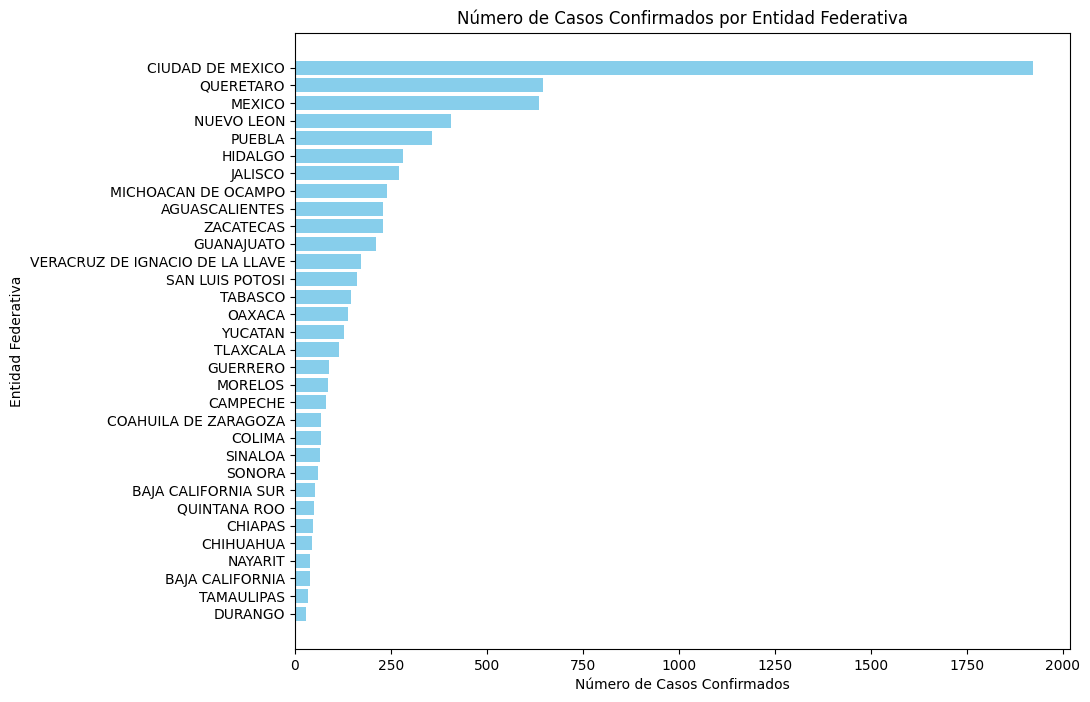

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo CSV resultante
input_file_path = r'E:\5toSemestre\A20_con_coordenadas.csv'

# Leer el archivo CSV resultante
data_a20 = pd.read_csv(input_file_path)

# Agrupar por entidad federativa y sumar los casos confirmados
casos_por_entidad = data_a20.groupby('Nombre del Estado de Residencia')['Numero de Casos Confirmados'].sum().reset_index()

# Ordenar los datos por número de casos confirmados
casos_por_entidad = casos_por_entidad.sort_values(by='Numero de Casos Confirmados', ascending=False)

# Crear una gráfica de barras
plt.figure(figsize=(10, 8))
plt.barh(casos_por_entidad['Nombre del Estado de Residencia'], casos_por_entidad['Numero de Casos Confirmados'], color='skyblue')
plt.xlabel('Número de Casos Confirmados')
plt.ylabel('Entidad Federativa')
plt.title('Número de Casos Confirmados por Entidad Federativa')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la entidad con más casos en la parte superior
plt.show()


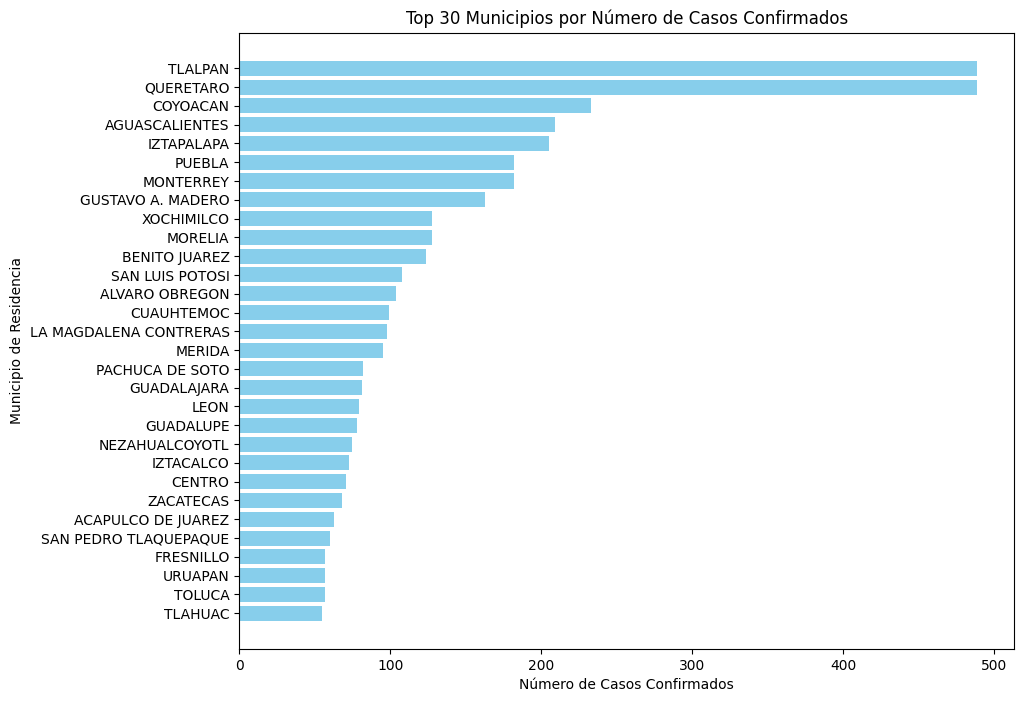

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo CSV resultante
input_file_path = r'E:\5toSemestre\A20_con_coordenadas.csv'

# Leer el archivo CSV resultante
data_a20 = pd.read_csv(input_file_path)

# Agrupar por municipio y sumar los casos confirmados
casos_por_municipio = data_a20.groupby('Nombre del Municipio de Residencia')['Numero de Casos Confirmados'].sum().reset_index()

# Ordenar los datos por número de casos confirmados
casos_por_municipio = casos_por_municipio.sort_values(by='Numero de Casos Confirmados', ascending=False)

# Seleccionar los 30 municipios con el mayor número de casos confirmados
top_30_municipios = casos_por_municipio.head(30)

# Crear una gráfica de barras
plt.figure(figsize=(10, 8))
plt.barh(top_30_municipios['Nombre del Municipio de Residencia'], top_30_municipios['Numero de Casos Confirmados'], color='skyblue')
plt.xlabel('Número de Casos Confirmados')
plt.ylabel('Municipio de Residencia')
plt.title('Top 30 Municipios por Número de Casos Confirmados')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar el municipio con más casos en la parte superior
plt.show()


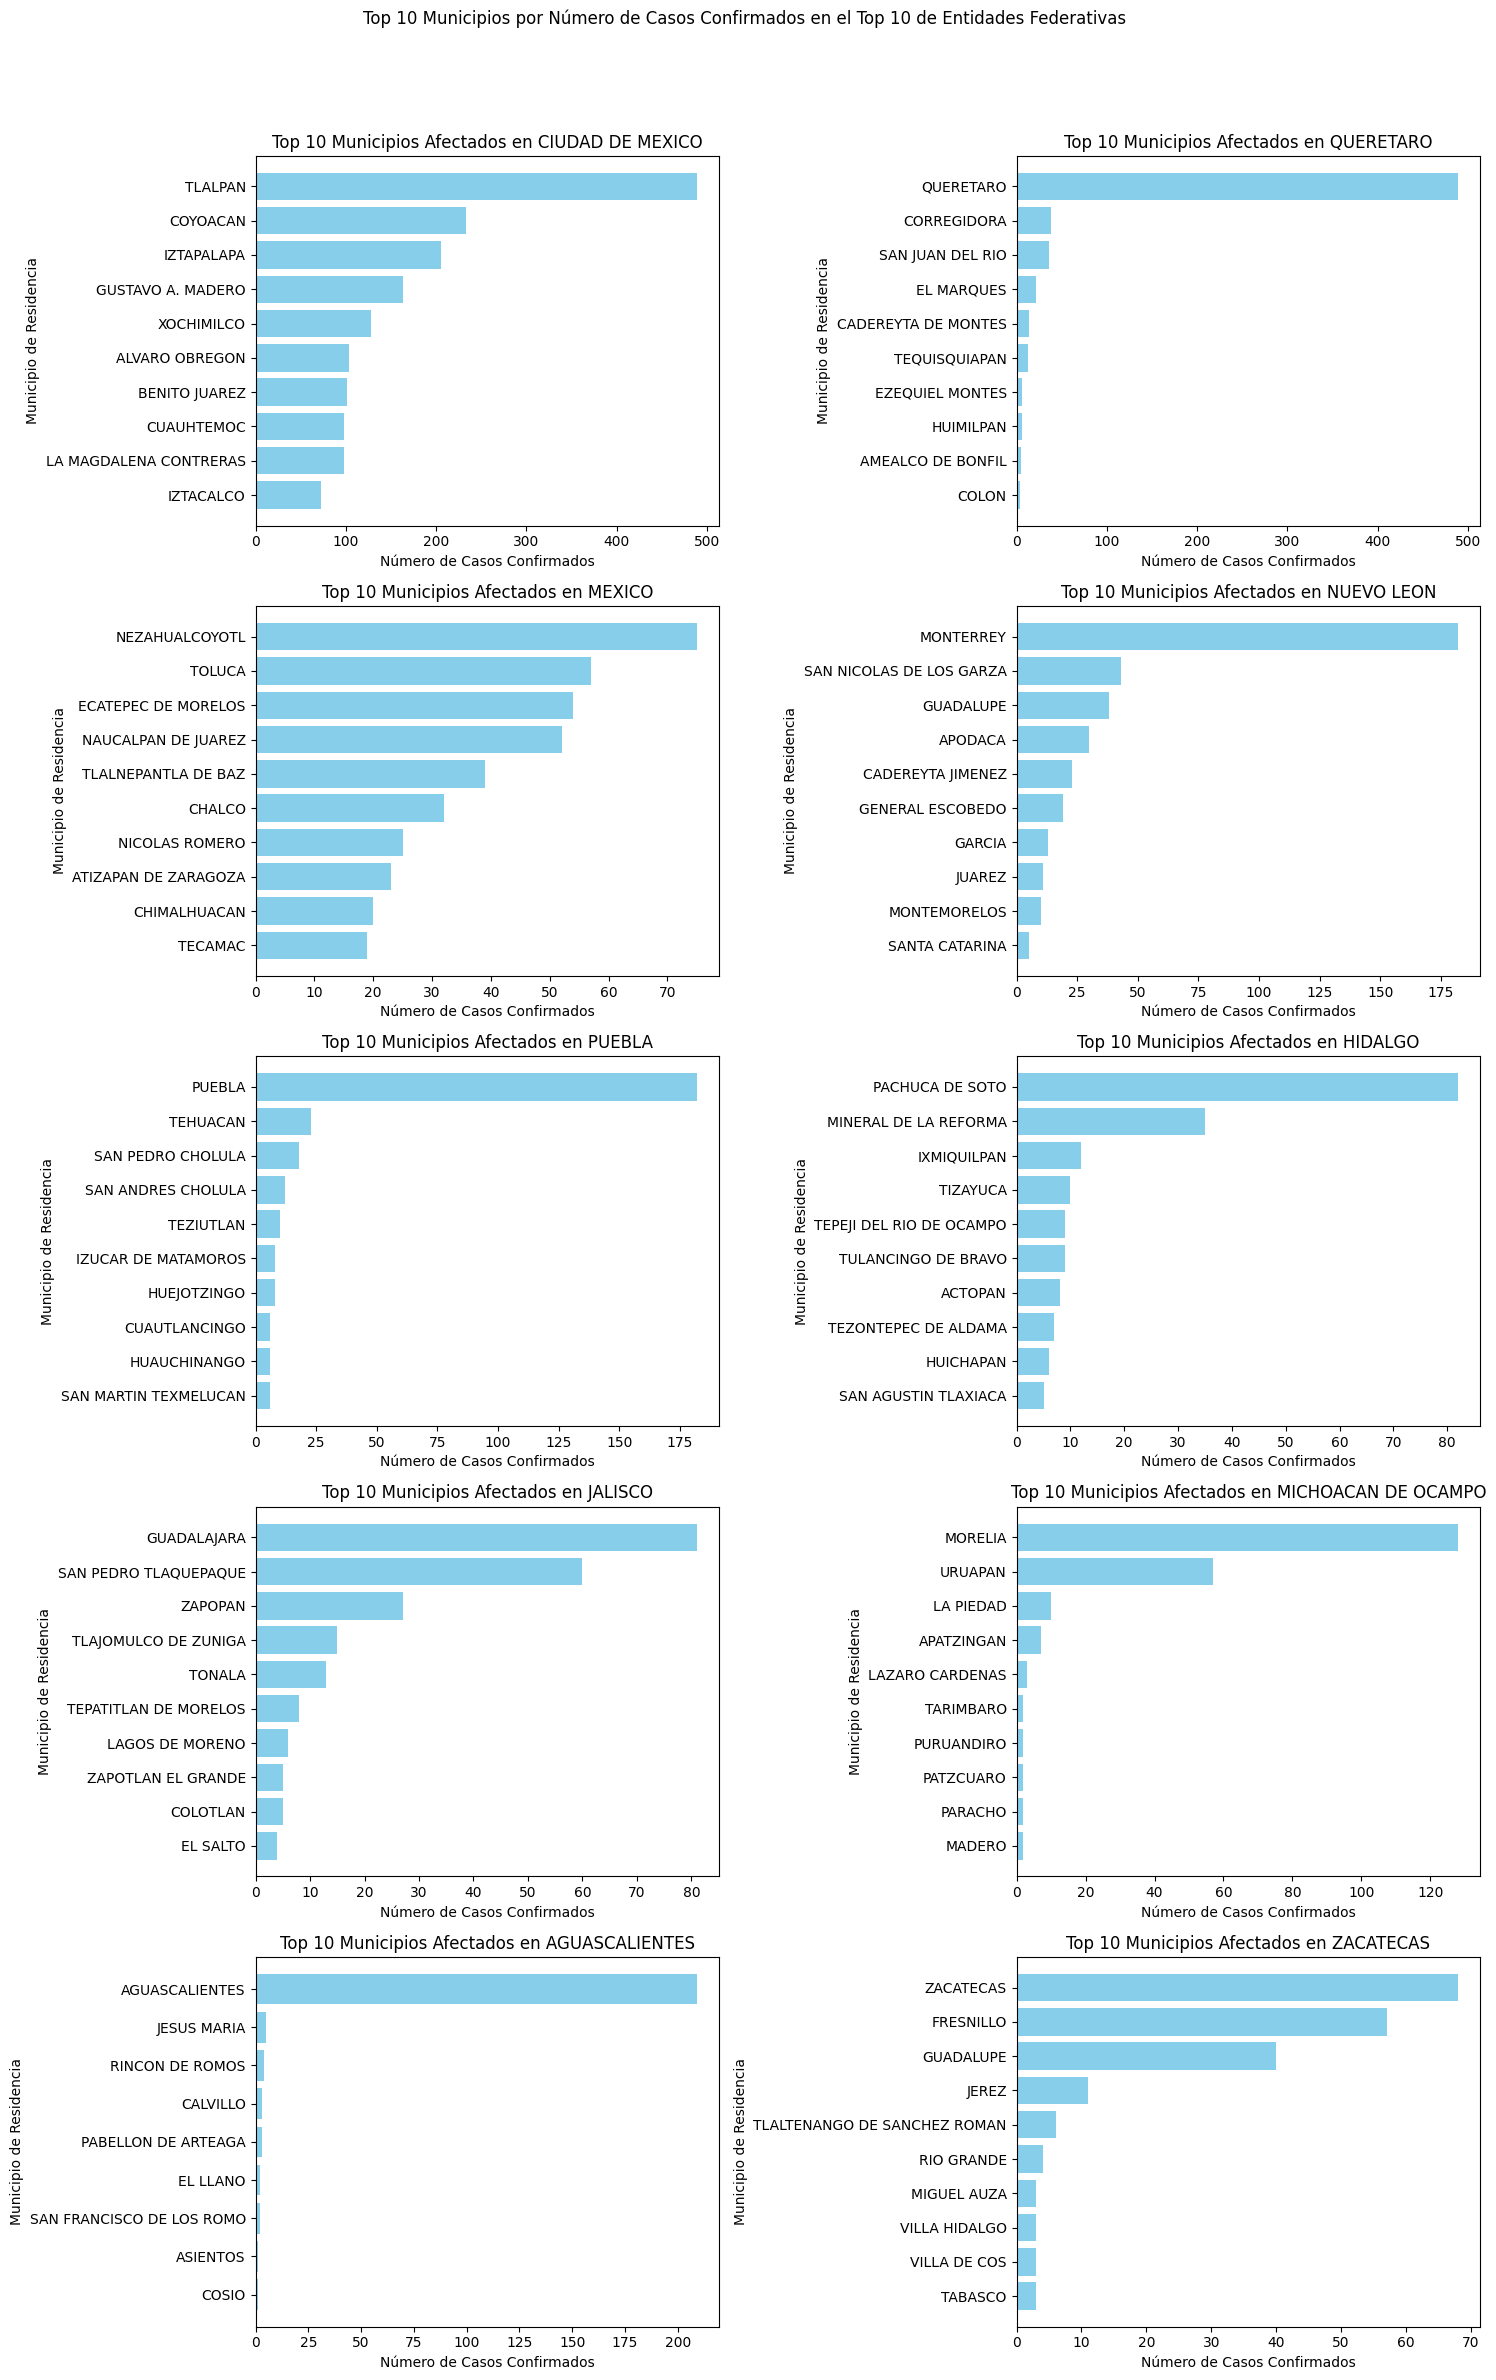

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo CSV resultante
input_file_path = r'E:\5toSemestre\A20_con_coordenadas.csv'

# Leer el archivo CSV resultante
data_a20 = pd.read_csv(input_file_path)

# Agrupar por entidad federativa y sumar los casos confirmados
casos_por_entidad = data_a20.groupby('Nombre del Estado de Residencia')['Numero de Casos Confirmados'].sum().reset_index()

# Ordenar los datos por número de casos confirmados y seleccionar el top 10 de entidades federativas
top_10_entidades = casos_por_entidad.sort_values(by='Numero de Casos Confirmados', ascending=False).head(10)['Nombre del Estado de Residencia']

# Crear una figura para las subtramas
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
fig.suptitle('Top 10 Municipios por Número de Casos Confirmados en el Top 10 de Entidades Federativas')

# Recorrer cada entidad del top 10
for i, entidad in enumerate(top_10_entidades):
    # Filtrar los datos para incluir sólo los registros de la entidad actual
    filtered_data = data_a20[data_a20['Nombre del Estado de Residencia'] == entidad]
    
    # Agrupar por municipio y sumar los casos confirmados
    casos_por_municipio = filtered_data.groupby('Nombre del Municipio de Residencia')['Numero de Casos Confirmados'].sum().reset_index()
    
    # Ordenar los datos por número de casos confirmados y seleccionar el top 10 de municipios
    top_10_municipios = casos_por_municipio.sort_values(by='Numero de Casos Confirmados', ascending=False).head(10)
    
    # Crear una gráfica de barras para la entidad actual
    ax = axs[i // 2, i % 2]
    ax.barh(top_10_municipios['Nombre del Municipio de Residencia'], top_10_municipios['Numero de Casos Confirmados'], color='skyblue')
    ax.set_xlabel('Número de Casos Confirmados')
    ax.set_ylabel('Municipio de Residencia')
    ax.set_title(f'Top 10 Municipios Afectados en {entidad}')
    ax.invert_yaxis()  # Invertir el eje Y para mostrar el municipio con más casos en la parte superior

# Ajustar el diseño de la figura
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
df_final = pd.read_csv("A20_con_coordenadas.csv")
df_final.head()

,FECHA_ACTUALIZACION,Nombre del estado de Nacimiento,Latitud Nacimiento,Longitud Nacimiento,Numero de Casos Confirmados,Nombre del Estado de Residencia,Latitud Residencia,Longitud Residencia,Nombre del Municipio de Residencia,Latitud Municipio Residencia,Longitud Municipio Residencia
0,2024-04-23,SAN LUIS POTOSI,22.500000,-100.494914,1,SAN LUIS POTOSI,22.500000,-100.494914,SAN LUIS POTOSI,22.500000,-100.494914
1,2024-04-23,OAXACA,17.000000,-96.500000,1,OAXACA,17.000000,-96.500000,OAXACA DE JUAREZ,17.060466,-96.725358
2,2024-04-23,CIUDAD DE MEXICO,19.432630,-99.133178,1,CIUDAD DE MEXICO,19.432630,-99.133178,ALVARO OBREGON,20.691286,-100.762885
3,2024-04-23,CHIHUAHUA,28.500000,-106.000000,1,CHIHUAHUA,28.500000,-106.000000,CHIHUAHUA,28.500000,-106.000000
4,2024-04-23,COLIMA,19.166667,-104.000000,1,COLIMA,19.166667,-104.000000,COLIMA,19.166667,-104.000000


In [31]:
df_final.columns

Index(['FECHA_ACTUALIZACION', 'Nombre del estado de Nacimiento',
       'Latitud Nacimiento', 'Longitud Nacimiento',
       'Numero de Casos Confirmados', 'Nombre del Estado de Residencia',
       'Latitud Residencia', 'Longitud Residencia',
       'Nombre del Municipio de Residencia', 'Latitud Municipio Residencia',
       'Longitud Municipio Residencia'],
      dtype='object')

 MAPPER

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import kmapper as km
from sklearn.cluster import DBSCAN
import webbrowser

# Cargar los datos
df_final = pd.read_csv("A20_con_coordenadas.csv")

# Normalizar datos
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_final[['Latitud Municipio Residencia', 'Longitud Municipio Residencia']].dropna())  # Eliminar filas con NaN

# Configurar y visualizar el Mapper
mapper = km.KeplerMapper(verbose=1)
lens = normalized_data
graph = mapper.map(lens, normalized_data, cover=km.Cover(n_cubes=10, perc_overlap=0.08))
html_output_path = "mapper_output.html"
mapper.visualize(graph, path_html=html_output_path, title="COVID-19 Topological Mapper")

# Abrir el archivo HTML en el navegador web
webbrowser.open(html_output_path)


KeplerMapper(verbose=1)
Mapping on data shaped (7148, 2) using lens shaped (7148, 2)

Creating 100 hypercubes.

Created 49 edges and 47 nodes in 0:00:00.460058.
Wrote visualization to: mapper_output.html


True

In [34]:
# Aplicar DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(normalized_data)
df_final = df_final.dropna(subset=['Latitud Municipio Residencia', 'Longitud Municipio Residencia'])  # Eliminar filas con NaN antes de agregar etiquetas
df_final['Cluster'] = db.labels_

# Guardar el resultado en un archivo CSV
df_final.to_csv('covid_clusters.csv', index=False)

In [ ]:
import pandas as pd
import kmapper as km
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Leer el archivo CSV resultante
input_file_path = r'E:\5toSemestre\A20_con_coordenadas.csv'
data_a20 = pd.read_csv(input_file_path)

# Verificar que la columna 'Región' está presente en los datos
if 'Región' not in data_a20.columns:
    # Diccionario de Regiones
    region_dict = {
        "AGUASCALIENTES": "BAJIO",
        "BAJA CALIFORNIA": "NORESTE",
        "BAJA CALIFORNIA SUR": "NORESTE",
        "CAMPECHE": "SURESTE",
        "CHIAPAS": "SURESTE",
        "CHIHUAHUA": "NORTE",
        "CIUDAD DE MEXICO": "MEXICO, D.F.",
        "COAHUILA DE ZARAGOZA": "NORTE",
        "COLIMA": "OCCIDENTE",
        "DURANGO": "NORTE",
        "GUANAJUATO": "BAJIO",
        "GUERRERO": "CENTRO Y GOLFO",
        "HIDALGO": "CENTRO Y GOLFO",
        "JALISCO": "OCCIDENTE",
        "MEXICO": "MEXICO, D.F.",
        "MICHOACAN DE OCAMPO": "OCCIDENTE",
        "MORELOS": "CENTRO Y GOLFO",
        "NAYARIT": "OCCIDENTE",
        "NUEVO LEON": "NORTE",
        "OAXACA": "CENTRO Y GOLFO",
        "PUEBLA": "CENTRO Y GOLFO",
        "QUERETARO": "BAJIO",
        "QUINTANA ROO": "SURESTE",
        "SAN LUIS POTOSI": "BAJIO",
        "SINALOA": "PACIFICO",
        "SONORA": "PACIFICO",
        "TABASCO": "SURESTE",
        "TAMAULIPAS": "NORTE",
        "TLAXCALA": "CENTRO Y GOLFO",
        "VERACRUZ DE IGNACIO DE LA LLAVE": "CENTRO Y GOLFO",
        "YUCATAN": "SURESTE",
        "ZACATECAS": "BAJIO"
    }
    
    # Asignar las regiones a los estados
    data_a20['Región'] = data_a20['Nombre del Estado de Residencia'].map(region_dict)

# Mostrar las primeras filas para verificar
print(data_a20.head())

# Diccionario de colores para cada región
region_colors = {
    "BAJIO": "purple",
    "NORESTE": "red",
    "SURESTE": "green",
    "NORTE": "blue",
    "OCCIDENTE": "yellow",
    "CENTRO Y GOLFO": "orange",
    "PACIFICO": "cyan",
    "MEXICO, D.F.": "magenta"
}

# Función para aplicar PCA y Mapper a cada región
def apply_mapper(region, df, color):
    mapper = km.KeplerMapper()
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(df[['Latitud Residencia', 'Longitud Residencia']])
    projected_data = mapper.fit_transform(pca_features, projection=[0, 1])
    cover = km.Cover(n_cubes=10, perc_overlap=0.08)
    clusterer = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    
    # Aplicar Mapper con los datos proyectados
    graph = mapper.map(projected_data, pca_features, cover=cover, clusterer=clusterer)
    
    # Visualizar el resultado en matplotlib para verificar colores
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=color, label=region)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.title(f'PCA Projection for {region}')
    plt.show()
    
    # Guardar la visualización con el color de la región
    output_path = f'C:\\Users\\DAVIDOmenlap\\Desktop\\Delete\\datos_abiertos_covid19\\Mapper bueno\\mapper_output_{region}.html'
    mapper.visualize(graph, path_html=output_path, title=region)

# Función para generar gráficos de barras de municipios más afectados por región
def plot_top_municipios_by_region(df, region):
    top_municipios = df[df['Región'] == region].groupby('Nombre del Municipio de Residencia')['Numero de Casos Confirmados'].sum().nlargest(15).reset_index()
    plt.barh(top_municipios['Nombre del Municipio de Residencia'], top_municipios['Numero de Casos Confirmados'], color=region_colors[region])
    plt.xlabel('Número de Casos Confirmados')
    plt.ylabel('Municipio de Residencia')
    plt.title(f'Top 15 Municipios Afectados en {region}')
    plt.show()

# Dividir el DataFrame por regiones
regions = data_a20['Región'].unique()

# Aplicar Mapper y generar gráficos por cada región
for region in regions:
    region_df = data_a20[data_a20['Región'] == region]
    color = region_colors[region]  # Obtener el color de la región
    apply_mapper(region, region_df, color)
    plot_top_municipios_by_region(data_a20, region)

#mapper y pca regional
#PCA 1 ES LATITUD Y PCA 2 ES LONGITUD 
# MAYOR DISTANCIA EN GRAFICO MAYOR DISTANCIA EN VIDA real 